# Module 6: Lab B - Transformations

Raster transformations are the operations that maps pixels of a source raster to a destination raster with an associated coordinate reference systems. The CRSs of source and destination raster may or may not be different.


There are many options for accessing imagery from a variety of sensors.  There are those that are free.  Even the free sites,  require an account to be created and tehn you will need to login.  Here is a website that lists many such sites for 'free' satellite imagery - https://eos.com/blog/free-satellite-imagery-sources/

To get around this, we are providing the links below in order to use Landsat 8 imagery in the following labs.

To perform transformations, we will use a Landsat-8 dataset in this lab. 
More information on Landsat-8 can be found [here](https://www.usgs.gov/land-resources/nli/landsat). 
We will be using two bands of the scene, red and near-infrared for the rest of the labs. 

Here are the links.

Red band - https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF

Near IR band - https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B5.TIF

##### Obtaining the red and near-infrared bands of Landsat-8 collection

##### Load raster data files

Let's load the raster files and visualize them.

In [ ]:
###############-----------------------------
### Loading
############## -----------------------------

import rasterio
import numpy as np
from pprint import pprint
import time

# start = time.time()

with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF') as src:
    redband = src.read()

with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B5.TIF') as src:
    nirband = src.read()
    
# end = time.time()
# print("It took {} milli-seconds to load the raster files".format((end-start)*1000))

In [ ]:
###############-----------------------------
### Visualizing
############## -----------------------------

from rasterio.plot import show
import matplotlib.pyplot as plt

%matplotlib inline

# start = time.time()

fig = plt.figure(figsize= (6,6))
rasterio.plot.show(redband)

fig = plt.figure(figsize= (6,6))
rasterio.plot.show(nirband)
# end = time.time()
# print("It took {} milli-seconds to display the raster files".format((end-start)*1000))

Your images should look like below.


---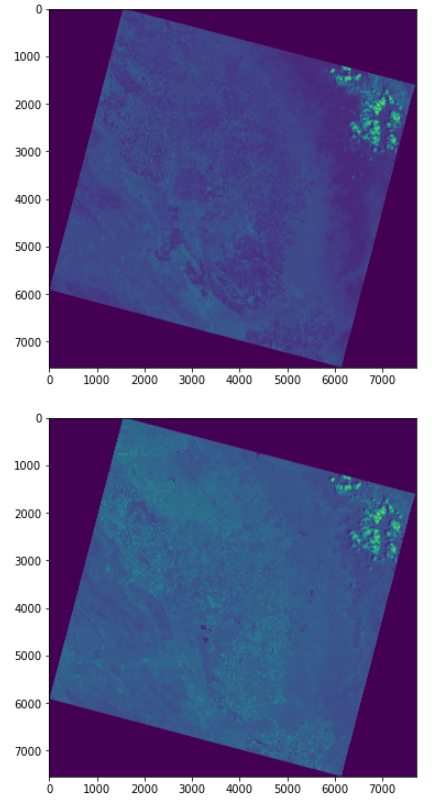


Looks like it took a good amount of time to load and visualize rasters. Uncomment the lines
``` python
#start = time.time()
........
#end = time.time()
#print("...".format((end-start)*1000))
```

in the above to cells to measure the time in milli-seconds and record the time.

### Why did it take so long? 

To understand the reason, let's check the size of each raster image.

In [ ]:
print(redband.shape)
print(nirband.shape)

Now you see the reason, the images are of size (1&times;7531&times;7711, i.e., 58 Megapixels), which is why it took so long to render the images. 
It takes a long time to preform any operation on such large images. 

So, the transformation that we will be learning in this lab is to reduce the size of image, 
while maintaining the resemblance with the original image. 
This is the **downsampling** transformation.

#### Downsampling
Downsampling is the process of converting high-resolution rasterdata (images) into lower-resolution images.
The following code presents the simplest way to downsample raster images using `rasterio`. 
As the images are of size (1&times;7531&times;7711), we shall reduce it to (1&times;753&times;771)

In [ ]:
import rasterio
import numpy as np

# Create an empty NumPy ND-array of the specified size and with the Unsigned Integer, 16-bit datatype
redband = np.empty(shape=(1,753,771), dtype = np.uint16)
nirband = np.empty(shape=(1,753,771), dtype = np.uint16)
with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF') as src:
    # Note, we provide a container to receive the data
    src.read(out = redband)

with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B5.TIF') as src:
    # Note, we provide a container to receive the data
    src.read(out= nirband)

To get an idea of performance gain, let's `time` the visualization code.

In [ ]:
from rasterio.plot import show
import matplotlib.pyplot as plt

%matplotlib inline

start = time.time()

fig = plt.figure(figsize= (6,6))
rasterio.plot.show(redband)

fig = plt.figure(figsize=(6,6))
rasterio.plot.show(nirband)

end = time.time()
print("It took {} milli-seconds to display the raster files".format((end-start)*1000))

From now on, we would be dealing with the downsampled images. 
Here we present another way of downsampling raster data, and save the downsampled images to the `temp` folder.

In the code, we create a new empty array `downsampled` to store the downsampled version of the original image, 
set its height and width to 1/10<sup>th</sup> of the height and widths of the original image. 

_Note: The type of variables `redband` and `downsampled` has to match. In our case, both of them are of `uint16`._

In [ ]:
from rasterio import Affine
from rasterio.warp import reproject
from rasterio.enums import Resampling
import numpy as np
%matplotlib inline

src = rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF')
redband = src.read()
height = round(redband.shape[1]/10)
width = round(redband.shape[2]/10)
downsampled = np.empty(shape = (redband.shape[0], height, width), dtype = np.uint16)


Before we proceed with the downsampling, let's inspect and understand the transform property of source raster.

In [ ]:
print(src.transform)

The transform is a $3x3$ array of numbers, an [Affine matrix](https://en.wikipedia.org/wiki/Affine_transformation),
the last elements in first and second rows correspond to the world coordinates of top left corner pixel of the raster data. 
First two diagonal elements represent the resolution in X and Y, respectively -- above example: $(X = 30,Y = -30)$. 
In this case, the raster has a resolution of 30m in height and width.

**Note:** The negative 30 is because in Image coordinates, Y gets larger as you move from Top-Left downward.
However, in geographic and mathematical coordinate spaces, the Y gets larger as you move upward.

When we try to reduce the size of the raster data, 
the world coordinates of the top left corner stays the same, only the resolution changes. 
As we are reducing the size by 10 in both `x` and `y` directions, the resolution has to increase by 10,
i.e., the downsampled image should have a resolution of 300m in `x` and `y` directions.

In [ ]:
import rasterio
from rasterio.enums import Resampling

with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF') as dataset:
    dataset.read(out = downsampled,
#        out_shape=(height, width, dataset.count),
        resampling=Resampling.average
    )
    
fig = plt.figure(figsize=(6,6))
rasterio.plot.show(downsampled)

We can then write the downsampled raster image to disk.

**Note:** _The downsampled version of raster images are used in next labs._

To create a new raster, we have to copy over some metadata and update other metadata.
Additionally, since we reduced the dimensions of the raster by a factor of 10, we must adjust the Affine matrix by increasing the pixel sizes, X and Y, from 30 to 300.

In [ ]:
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling

with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B4.TIF') as dataset:
    dataset.read(out = downsampled,
#        out_shape=(height, width, dataset.count),
        resampling=Resampling.average
    )
       
    # The pixels are going to scale to 10x from 30 m to 300 m
    dst_transform = dataset.transform * Affine.scale(10,10)
    print(dst_transform)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': dst_transform,
        'width' : width,
        'height': height
    })

    with rasterio.open('../temp/redband_downsampled.TIF','w', **kwargs) as dst:
        dst.write(downsampled)
    

Load and visualize the downsampled raster to make sure it resembles the original raster.

In [ ]:
with rasterio.open('../temp/redband_downsampled.TIF') as src:
    print(src.transform)
    print(src.crs)
    fig = plt.figure(figsize = (6,6))
    rasterio.plot.show(src.read())

### Now let's down sample the `nearIRband.TIF` following the above procedure and save it as `nearIRband_downsampled.TIF`.
****

In [ ]:
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
import numpy as np
%matplotlib inline

src = rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B5.TIF')
nirband = src.read()
height = round(nirband.shape[1]/10)  
width = round(nirband.shape[2]/10)   
downsampled = np.empty(shape = (nirband.shape[0], height, width), dtype = np.uint16)


In [ ]:
with rasterio.open('https://web.dsa.missouri.edu/static/data/geodata/LC80420352013156LGN00_B5.TIF') as dataset:
    dataset.read(out = downsampled,
#        out_shape=(height, width, dataset.count),
        resampling=Resampling.average
    )
       
    # The pixels are going to scale to 10x from 30 m to 300 m
    dst_transform = dataset.transform * Affine.scale(10,10)
    print(dst_transform)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': src.crs,
        'transform': dst_transform,
        'width' : width,
        'height': height
    })

    with rasterio.open('../temp/nearIRband_downsampled.TIF','w', **kwargs) as dst:
        dst.write(downsampled)


In [ ]:
with rasterio.open('../temp/nearIRband_downsampled.TIF') as src:
    print(src.transform)
    print(src.crs)
    fig = plt.figure(figsize = (6,6))
    rasterio.plot.show(src.read())

****
# Save your Notebook
## Then, File > Close and Halt